# VAMOS quickstart: user-friendly API

This notebook shows the simplified VAMOS API for running multi-objective optimizers, inspecting results, plotting fronts, and saving outputs.

## Setup

In [18]:
from vamos import run_nsgaii, run_moead, run_spea2, run_nsgaiii
import matplotlib.pyplot as plt
import pandas as pd

SEED = 42

## NSGA-II on ZDT1

In [19]:
result = run_nsgaii(
    "zdt1",
    max_evaluations=10000,
    pop_size=100,
    crossover_prob=0.9,
    crossover_eta=20,
    mutation_eta=20,
    seed=SEED,
)


In [20]:
result.summary()

=== VAMOS Quick Result ===
Algorithm: NSGAII
Solutions: 100
Objectives: 2
Evaluations: 10000
Seed: 42

Objective ranges:
  f1: [0.000001, 0.998910]
  f2: [0.020138, 1.479031]

Hypervolume (auto ref): 1.419497


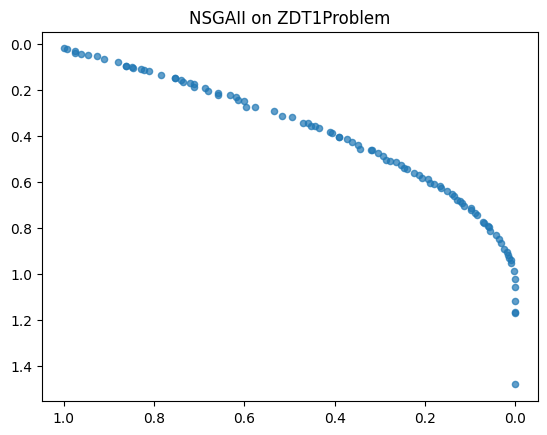

<Axes: title={'center': 'NSGAII on ZDT1Problem'}>

In [21]:
result.plot()

In [22]:
# Knee point (balanced trade-off)
knee = result.best("knee")
print("Knee point:")
print(f"  Objectives: {knee['F']}")
print(f"  Index: {knee['index']}")


Knee point:
  Objectives: [0.14022074 0.65172893]
  Index: 52


In [23]:
df = result.to_dataframe()
df.head(10)


,f1,f2,x1,x2,x3,x4,x5,x6,x7,x8,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,5.826351e-07,1.479031,5.826351e-07,0.007074,0.006754,0.159477,0.007169,0.057344,0.019122,0.013273,...,0.084480,0.061183,0.025516,0.019049,0.001284,0.016954,0.207089,0.375086,0.000989,0.059131
1,9.989104e-01,0.020138,9.989104e-01,0.003172,0.001077,0.008539,0.002410,0.001339,0.001058,0.004188,...,0.001405,0.000397,0.000545,0.002977,0.000334,0.000360,0.004630,0.008300,0.008666,0.000636
2,6.029057e-07,1.168878,6.029057e-07,0.001554,0.017848,0.012189,0.000558,0.043711,0.025758,0.015062,...,0.007964,0.000600,0.025908,0.000160,0.002142,0.002231,0.000384,0.007355,0.005812,0.035207
3,4.204525e-06,1.118506,4.204525e-06,0.001991,0.018674,0.014924,0.004167,0.006997,0.001573,0.003216,...,0.007880,0.000610,0.020421,0.000454,0.001635,0.005262,0.002033,0.008261,0.005856,0.000857
4,9.668449e-05,1.057180,9.668449e-05,0.001991,0.001038,0.014367,0.004202,0.006493,0.001360,0.001242,...,0.001206,0.000004,0.016606,0.003148,0.001642,0.005235,0.004683,0.008290,0.015715,0.000607
5,7.852583e-01,0.134412,7.852583e-01,0.002185,0.000241,0.000786,0.001889,0.001906,0.001272,0.002295,...,0.008407,0.000035,0.000504,0.000204,0.001772,0.000180,0.001727,0.020180,0.001111,0.001208
6,6.799554e-04,1.022587,6.799554e-04,0.010213,0.001041,0.000792,0.000590,0.004182,0.001066,0.003796,...,0.002477,0.000682,0.001171,0.003045,0.000362,0.006093,0.005524,0.006139,0.008215,0.004740
7,4.349794e-01,0.367484,4.349794e-01,0.000565,0.009686,0.000708,0.001908,0.003472,0.001862,0.000936,...,0.004533,0.003934,0.002406,0.002743,0.000349,0.006017,0.000718,0.008191,0.001266,0.001974
8,9.263338e-01,0.054763,9.263338e-01,0.011852,0.000648,0.000265,0.005453,0.003343,0.000365,0.000144,...,0.000889,0.000875,0.000393,0.001351,0.001751,0.001412,0.001925,0.009210,0.008296,0.008703
9,6.325847e-01,0.223055,6.325847e-01,0.012041,0.001291,0.002182,0.001700,0.004766,0.000704,0.002079,...,0.001275,0.000916,0.001053,0.002914,0.001597,0.005323,0.000634,0.007643,0.001140,0.001951


In [24]:
# Save to a directory
result.save("results/notebook_example")


Results saved to results\notebook_example


## Comparing algorithms on ZDT1

In [25]:
r1 = run_nsgaii("zdt1", max_evaluations=10000, pop_size=100, seed=SEED)
r2 = run_moead("zdt1", max_evaluations=10000, pop_size=100, seed=SEED)
r3 = run_spea2("zdt1", max_evaluations=10000, pop_size=100, seed=SEED)

print(f"NSGA-II solutions: {len(r1)}")
print(f"MOEA/D solutions: {len(r2)}")
print(f"SPEA2 solutions: {len(r3)}")


NSGA-II solutions: 100
MOEA/D solutions: 98
SPEA2 solutions: 100


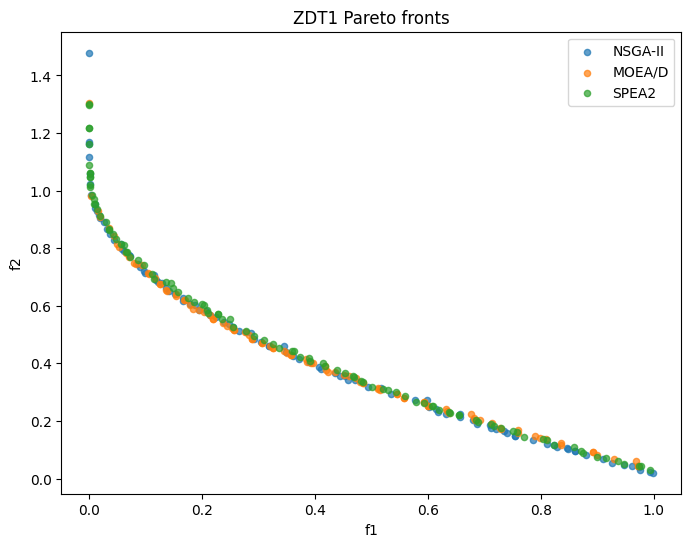

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(r1.F[:, 0], r1.F[:, 1], label="NSGA-II", alpha=0.7, s=20)
ax.scatter(r2.F[:, 0], r2.F[:, 1], label="MOEA/D", alpha=0.7, s=20)
ax.scatter(r3.F[:, 0], r3.F[:, 1], label="SPEA2", alpha=0.7, s=20)
ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_title("ZDT1 Pareto fronts")
ax.legend()
plt.show()


## NSGA-III on DTLZ2 (3 objectives)

In [27]:
result_3d = run_nsgaiii(
    "dtlz2",
    n_obj=3,
    max_evaluations=10000,
    pop_size=92,
    seed=SEED,
)


In [28]:
result_3d.summary()

=== VAMOS Quick Result ===
Algorithm: NSGAIII
Solutions: 92
Objectives: 3
Evaluations: 10000
Seed: 42

Objective ranges:
  f1: [0.000000, 0.000000]
  f2: [0.000000, 0.000000]
  f3: [0.000000, 0.000000]


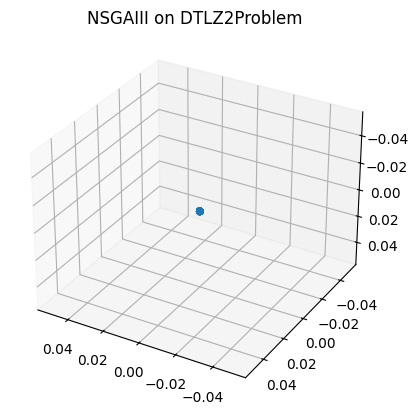

<Axes3D: title={'center': 'NSGAIII on DTLZ2Problem'}>

In [29]:
result_3d.plot()